In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

import warnings
warnings.filterwarnings('ignore')

# load data
df = pd.read_excel('AirQualityUCI.xlsx')

# Initial overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9357 non-null   datetime64[ns]
 1   Time           9357 non-null   object        
 2   CO(GT)         9357 non-null   float64       
 3   PT08.S1(CO)    9357 non-null   float64       
 4   NMHC(GT)       9357 non-null   int64         
 5   C6H6(GT)       9357 non-null   float64       
 6   PT08.S2(NMHC)  9357 non-null   float64       
 7   NOx(GT)        9357 non-null   float64       
 8   PT08.S3(NOx)   9357 non-null   float64       
 9   NO2(GT)        9357 non-null   float64       
 10  PT08.S4(NO2)   9357 non-null   float64       
 11  PT08.S5(O3)    9357 non-null   float64       
 12  T              9357 non-null   float64       
 13  RH             9357 non-null   float64       
 14  AH             9357 non-null   float64       
dtypes: datetime64[ns](1),

In [2]:
# null values
df.isnull().sum()

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

In [3]:
# duplicates
df.duplicated().sum()

0

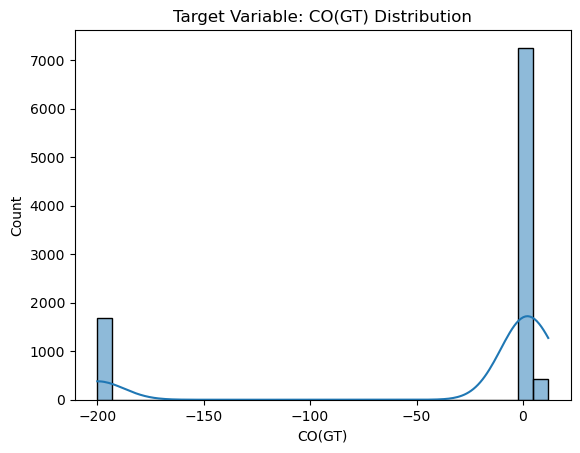

In [4]:
sns.histplot(df['CO(GT)'], kde=True, bins=30)
plt.title('Target Variable: CO(GT) Distribution')
plt.xlabel('CO(GT)')
plt.show()

In [5]:
# Set datetime index
df.set_index('Date', inplace=True)

Features Engineering

In [6]:
# Extract hour and day features
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour
df = df.drop(columns=['Time'])
df['DayOfWeek'] = df.index.dayofweek  # Monday=0, Sunday=6
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Interaction feature
df['Temp_Hum_Interaction'] = df['T'] * df['RH']
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9357 entries, 2004-03-10 to 2005-04-04
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CO(GT)                9357 non-null   float64
 1   PT08.S1(CO)           9357 non-null   float64
 2   NMHC(GT)              9357 non-null   int64  
 3   C6H6(GT)              9357 non-null   float64
 4   PT08.S2(NMHC)         9357 non-null   float64
 5   NOx(GT)               9357 non-null   float64
 6   PT08.S3(NOx)          9357 non-null   float64
 7   NO2(GT)               9357 non-null   float64
 8   PT08.S4(NO2)          9357 non-null   float64
 9   PT08.S5(O3)           9357 non-null   float64
 10  T                     9357 non-null   float64
 11  RH                    9357 non-null   float64
 12  AH                    9357 non-null   float64
 13  Hour                  9357 non-null   int32  
 14  DayOfWeek             9357 non-null   int32  
 15  IsW

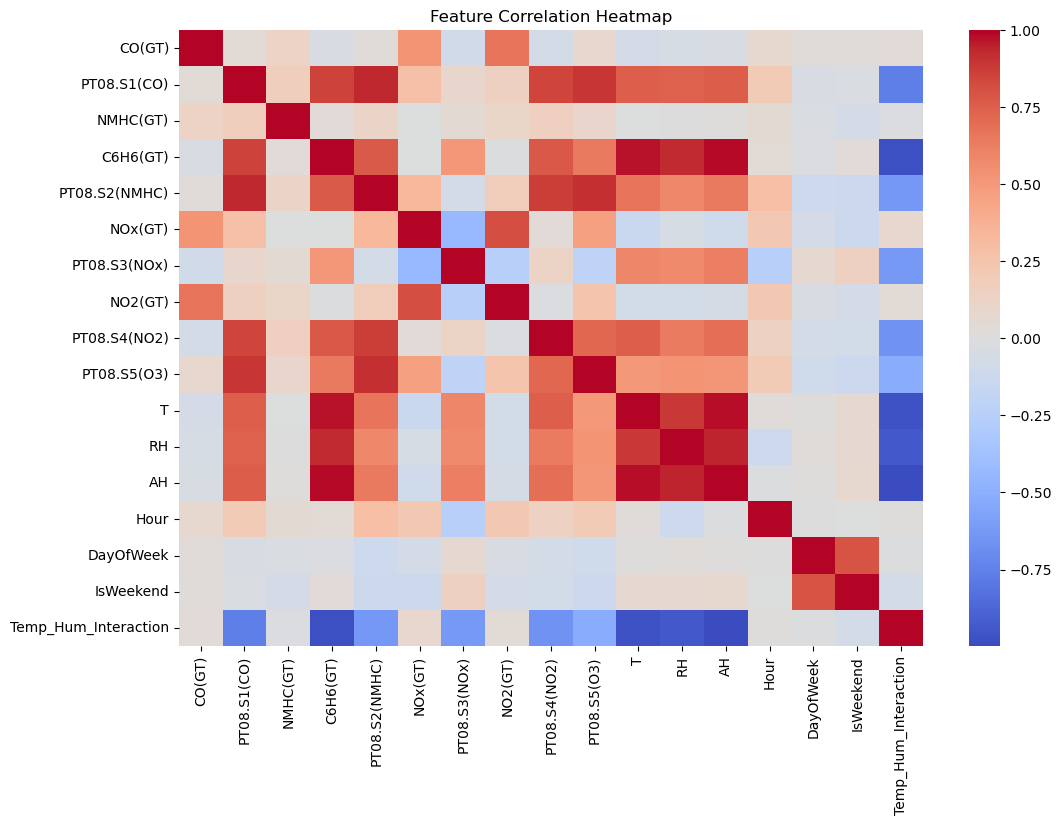

In [7]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

Detecting Outliers

In [8]:
original_df = df.copy()

# Calculate original outliers for reference
Q1_orig = original_df.quantile(0.25)
Q3_orig = original_df.quantile(0.75)
IQR_orig = Q3_orig - Q1_orig
original_outliers = ((original_df < (Q1_orig - 1.5 * IQR_orig)) |
                     (original_df > (Q3_orig + 1.5 * IQR_orig)))
original_outlier_counts = original_outliers.sum()

Applying outlier treatments...
✓ CO(GT): KEPT outliers (real pollution events)
✓ NO2(GT): KEPT outliers (real pollution events)
✓ NOx(GT): KEPT outliers (real pollution events)
✓ PT08.S1(CO): CAPPED at 1703.72 (99th percentile)
✓ PT08.S2(NMHC): CAPPED at 1641.80 (99th percentile)
✓ PT08.S3(NOx): CAPPED at 1651.38 (99th percentile)
✓ PT08.S4(NO2): CAPPED at 2349.59 (99th percentile)
✓ PT08.S5(O3): CAPPED at 2086.00 (99th percentile)
✓ AH: CAPPED at 1.96 (99th percentile)
✓ NMHC(GT): CAPPED at 144.20 (95th percentile)
✓ C6H6(GT): CAPPED at 24.43 (95th percentile)
✓ RH: CLIPPED to valid range (0-100%)
✓ Temp_Hum_Interaction: RECALCULATED as T × RH

OUTLIER TREATMENT SUMMARY
                      Original_Outliers  After_Treatment  Reduction  \
CO(GT)                             1898             1841         57   
PT08.S1(CO)                         484              117        367   
NMHC(GT)                            914              887         27   
C6H6(GT)                            

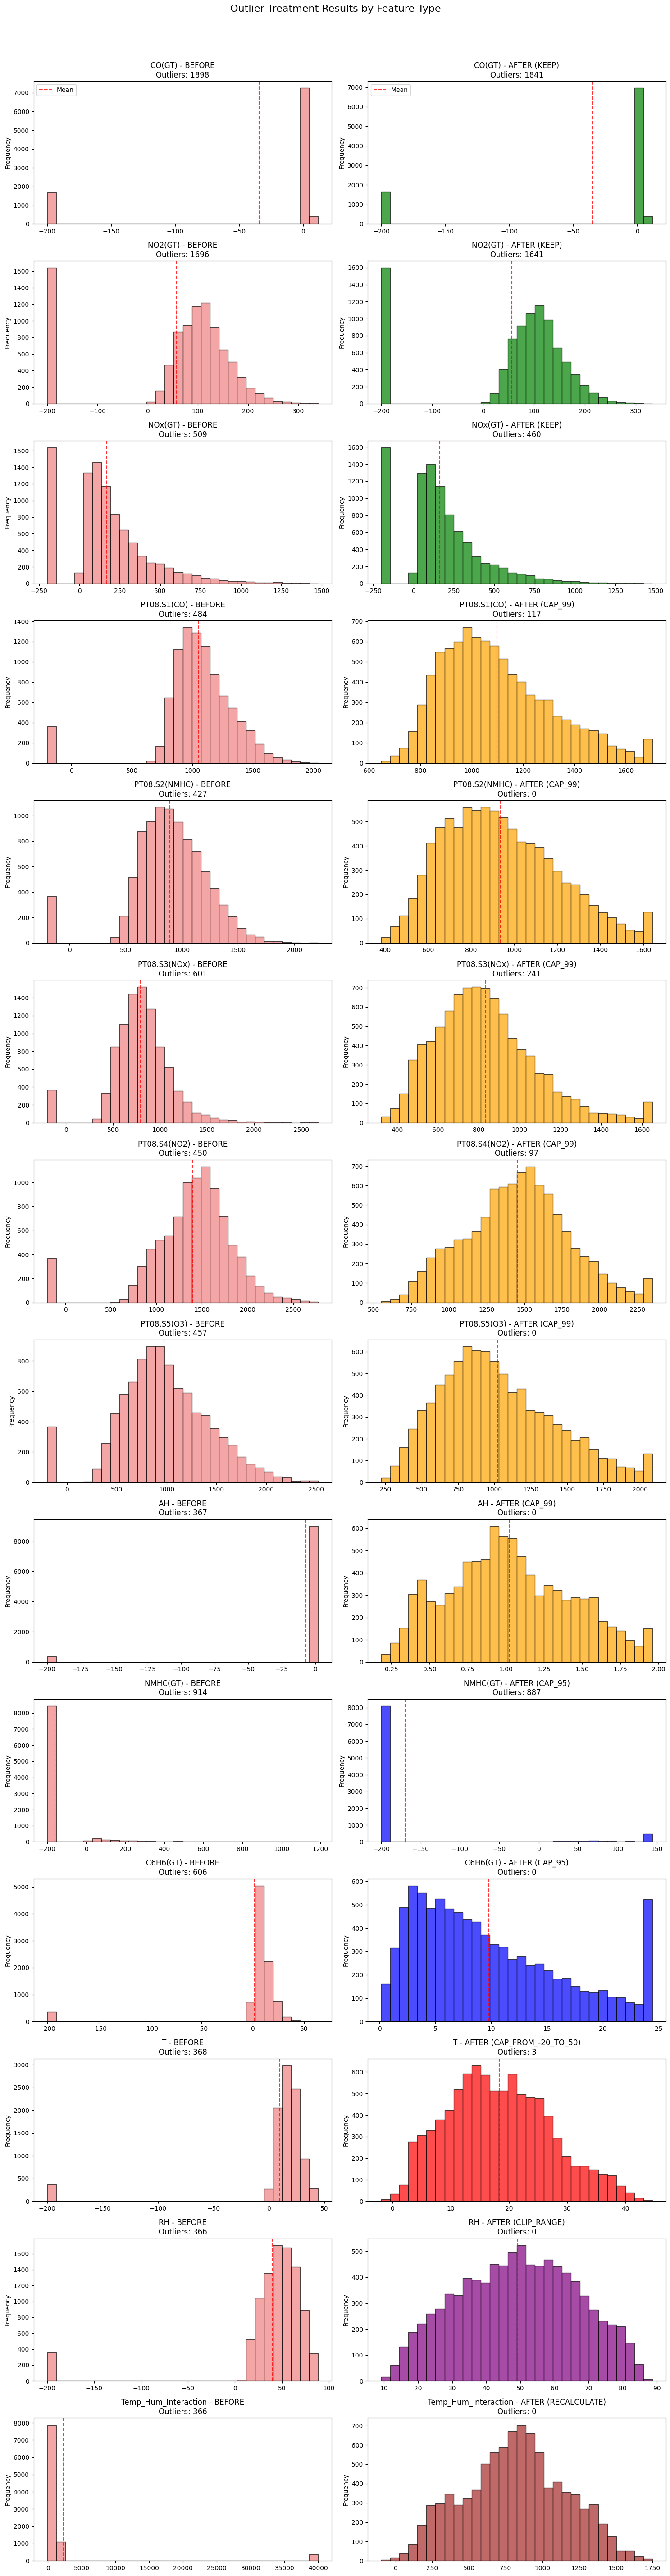


TREATMENT METHOD SUMMARY
KEEP: CO(GT), NO2(GT), NOx(GT)
CAP_99: PT08.S1(CO), PT08.S2(NMHC), PT08.S3(NOx), PT08.S4(NO2), PT08.S5(O3), AH
CAP_95: NMHC(GT), C6H6(GT)
CAP_FROM_-20_TO_50: T
CLIP_RANGE: RH
RECALCULATE: Temp_Hum_Interaction


In [9]:
adjusted_cols = []

# Define treatment strategies
treatment_strategy = {
    # Keep outliers (no treatment)
    'keep': ['CO(GT)', 'NO2(GT)', 'NOx(GT)'],

    # Cap at 99th percentile
    'cap_99': ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'AH'],

    # Cap at 95th percentile
    'cap_95': ['NMHC(GT)', 'C6H6(GT)'],

    # Replace with median (for meteorological data)
    'cap_from_-20_to_50': ['T'],

    # Clip to valid range
    'clip_range': ['RH'],  # 0-100%

    # Recalculate (derived features)
    'recalculate': ['Temp_Hum_Interaction']
}


print("Applying outlier treatments...")
print("=" * 50)

# 1. Keep outliers (no action needed)
for col in treatment_strategy['keep']:
    if col in df.columns:
        print(f"✓ {col}: KEPT outliers (real pollution events)")
        adjusted_cols.append(col)

# 2. Cap at 99th percentile
# Analysis: These are sensor responses that may saturate at very high concentrations
# Action: CAP at 99th percentile rather than remove
# Justification: Sensors have physical limits; extreme values might be measurement artifacts, but moderate outliers are validfor col in treatment_strategy['cap_99']:
for col in treatment_strategy['cap_99']:
    if col in df.columns:
        cap_value = original_df[col].quantile(0.99)
        df[col] = df[col].clip(upper=cap_value)
        print(f"✓ {col}: CAPPED at {cap_value:.2f} (99th percentile)")
        adjusted_cols.append(col)

# 3. Cap at 95th percentile
# Analysis: These can spike due to industrial emissions or traffic events
# Action: CAP at 95th percentile
# Justification: Some spikes are real, but extreme values might be measurement errors
for col in treatment_strategy['cap_95']:
    if col in df.columns:
        cap_value = original_df[col].quantile(0.95)
        df[col] = df[col].clip(upper=cap_value)
        print(f"✓ {col}: CAPPED at {cap_value:.2f} (95th percentile)")
        adjusted_cols.append(col)

# 4. Replace with median (seasonal for temperature)
# Expected Range (Rome dataset): ~ -10°C to 40°C
# Outliers: Anything outside that is likely due to sensor errors or time synchronization issues.
for col in treatment_strategy['cap_from_-20_to_50']:
    if col in df.columns:
        if col == 'T':
            df = df[(df['T'] > -20) & (df['T'] < 50)]
        adjusted_cols.append(col)

# 5. Clip to valid range
# Analysis: RH should be 0-100%; outliers are sensor errors
# Action: CLIP to 0-100% range
# Justification: Physical impossibility of RH > 100% or RH < 0%
for col in treatment_strategy['clip_range']:
    if col in df.columns:
        if col == 'RH':
            df[col] = df[col].clip(0, 100)
            print(f"✓ {col}: CLIPPED to valid range (0-100%)")
        adjusted_cols.append(col)

# 6. Recalculate derived features
for col in treatment_strategy['recalculate']:
    if col in df.columns:
        if col == 'Temp_Hum_Interaction':
            df[col] = df['T'] * df['RH']
            print(f"✓ {col}: RECALCULATED as T × RH")
        adjusted_cols.append(col)

# Calculate new outliers after treatment
Q1_new = df.quantile(0.25)
Q3_new = df.quantile(0.75)
IQR_new = Q3_new - Q1_new
new_outliers = ((df < (Q1_new - 1.5 * IQR_new)) | (df > (Q3_new + 1.5 * IQR_new)))
new_outlier_counts = new_outliers.sum()

print("\n" + "=" * 50)
print("OUTLIER TREATMENT SUMMARY")
print("=" * 50)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Original_Outliers': original_outlier_counts,
    'After_Treatment': new_outlier_counts,
    'Reduction': original_outlier_counts - new_outlier_counts,
    'Reduction_Pct': ((original_outlier_counts - new_outlier_counts) / original_outlier_counts * 100).fillna(0)
})

print(comparison_df[comparison_df['Original_Outliers'] > 0].round(1))

# Enhanced Visualization with treatment labels
adjusted_cols_with_outliers = [col for col in adjusted_cols if original_outlier_counts[col] > 0]
n_cols = len(adjusted_cols_with_outliers)

if n_cols == 0:
    print("No columns with outliers were treated!")
else:
    # Create comprehensive visualization
    fig, axes = plt.subplots(n_cols, 2, figsize=(15, 4 * n_cols))
    if n_cols == 1:
        axes = axes.reshape(1, -1)

    # Color mapping for treatments
    treatment_colors = {
        'keep': 'green', 'cap_99': 'orange', 'cap_95': 'blue',
        'cap_from_-20_to_50': 'red', 'clip_range': 'purple', 'recalculate': 'brown'
    }

    for i, col in enumerate(adjusted_cols_with_outliers):
        # Determine treatment type
        treatment_type = 'keep'  # default
        for treatment, cols in treatment_strategy.items():
            if col in cols:
                treatment_type = treatment
                break

        color = treatment_colors.get(treatment_type, 'gray')

        # Before
        axes[i, 0].hist(original_df[col], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
        axes[i, 0].set_title(f'{col} - BEFORE\nOutliers: {original_outlier_counts[col]}')
        axes[i, 0].set_ylabel('Frequency')

        # After
        axes[i, 1].hist(df[col], bins=30, alpha=0.7, color=color, edgecolor='black')
        axes[i, 1].set_title(f'{col} - AFTER ({treatment_type.upper()})\nOutliers: {new_outlier_counts[col]}')
        axes[i, 1].set_ylabel('Frequency')

        # Add statistics
        axes[i, 0].axvline(original_df[col].mean(), color='red', linestyle='--', alpha=0.8, label='Mean')
        axes[i, 1].axvline(df[col].mean(), color='red', linestyle='--', alpha=0.8, label='Mean')

        if i == 0:  # Add legend only to first row
            axes[i, 0].legend()
            axes[i, 1].legend()

    plt.tight_layout()
    plt.suptitle('Outlier Treatment Results by Feature Type', y=1.02, fontsize=16)
    plt.show()

# Create treatment summary table
print("\n" + "=" * 50)
print("TREATMENT METHOD SUMMARY")
print("=" * 50)
for treatment, cols in treatment_strategy.items():
    existing_cols = [col for col in cols if col in df.columns]
    if existing_cols:
        print(f"{treatment.upper()}: {', '.join(existing_cols)}")

Dataset shape: (8991, 15)
Target variable stats:
count    8991.000000
mean        9.782144
std         6.582022
min         0.149048
25%         4.436942
50%         8.239851
75%        13.988478
max        24.432425
Name: C6H6(GT), dtype: float64
Training set: (5753, 15)
Validation set: (1439, 15)
Test set: (1799, 15)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,889 (54.25 KB)

 Trainable params: 13,409 (52.38 KB)

 Non-trainable params: 480 (1.88 KB)

Training the MLP model...
Epoch 1/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 2.0010 - mae: 1.0838 - val_loss: 0.2462 - val_mae: 0.4020 - learning_rate: 0.0010
Epoch 2/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6353 - mae: 0.6273 - val_loss: 0.0879 - val_mae: 0.2414 - learning_rate: 0.0010
Epoch 3/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3939 - mae: 0.4917 - val_loss: 0.0594 - val_mae: 0.1975 - learning_rate: 0.0010
Epoch 4/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3003 - mae: 0.4278 - val_loss: 0.0456 - val_mae: 0.1704 - learning_rate: 0.0010
Epoch 5/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2506 - mae: 0.3911 - val_loss: 0.0384 - val_mae: 0.1529 - learning_rate: 0.0010
Epoch 6/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2175 - mae: 0.3606 - val_loss: 0.0352 - val_mae: 0.1469 - learning_rate: 0.0010
Epoch 7/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1947 - mae: 0.3413 - val_loss: 0.0337 - val_mae: 0.14

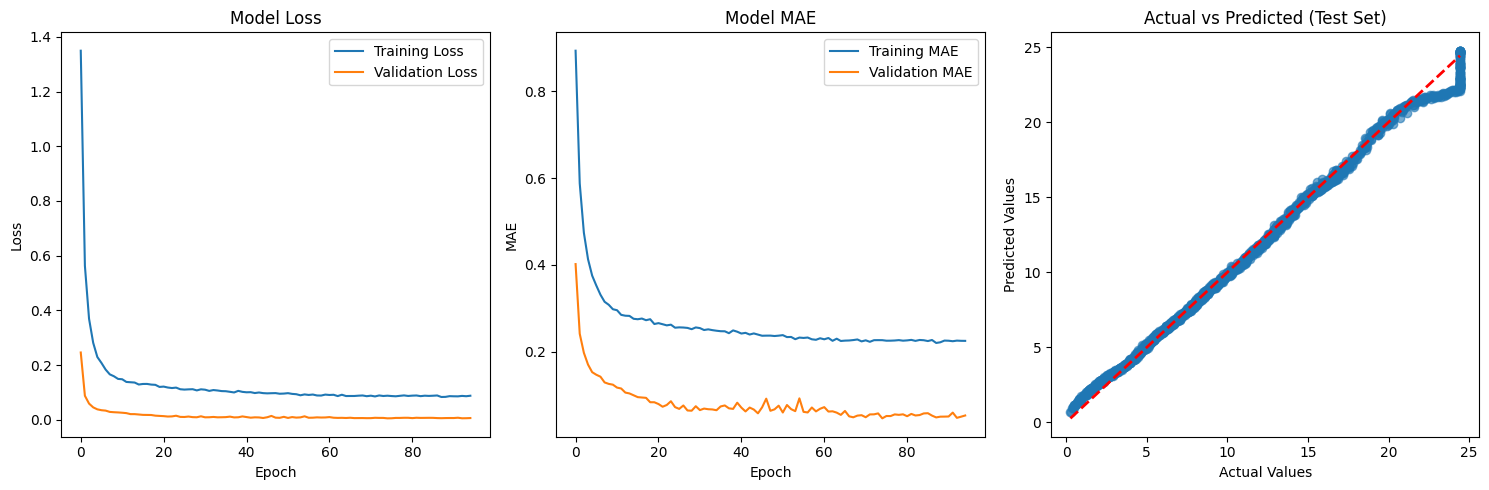

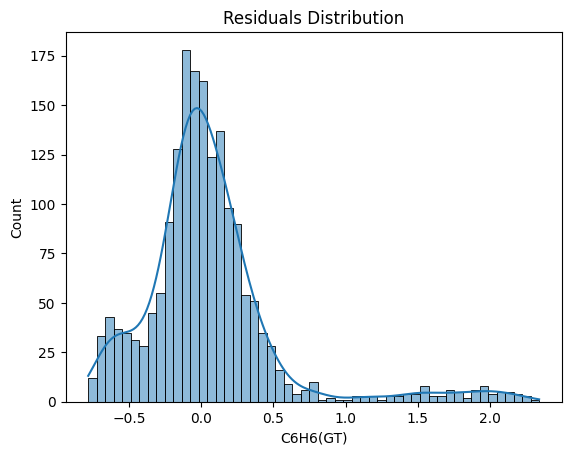

Calculating permutation importance...


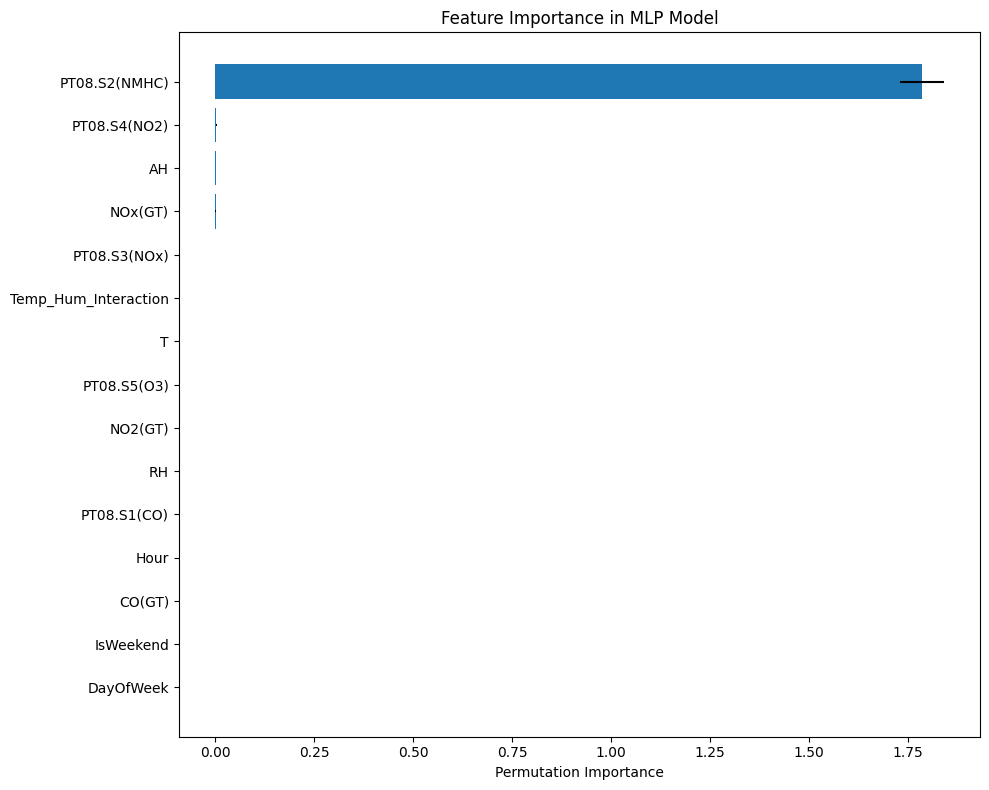


Feature Importance Ranking:
PT08.S2(NMHC): 1.784076 ± 0.055310
PT08.S4(NO2): 0.003321 ± 0.000122
AH: 0.000984 ± 0.000113
NOx(GT): 0.000841 ± 0.000081
PT08.S3(NOx): 0.000709 ± 0.000032
Temp_Hum_Interaction: 0.000689 ± 0.000114
T: 0.000604 ± 0.000092
PT08.S5(O3): 0.000480 ± 0.000041
NO2(GT): 0.000123 ± 0.000024
RH: 0.000096 ± 0.000039
PT08.S1(CO): 0.000092 ± 0.000016
Hour: 0.000070 ± 0.000007
CO(GT): 0.000067 ± 0.000011
IsWeekend: 0.000026 ± 0.000012
DayOfWeek: -0.000054 ± 0.000018

Model Complexity:
Total parameters: 13,889
Trainable parameters: 13,409

Model and scalers saved successfully!
Files saved: mlp_benzene_model.h5, scaler_X.pkl, scaler_y.pkl


In [10]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Predictor features
features = [
    'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)',
    'PT08.S5(O3)','CO(GT)', 'NO2(GT)', 'NOx(GT)','T', 'RH', 'AH', 'Hour',
    'DayOfWeek', 'IsWeekend', 'Temp_Hum_Interaction'
]
target = 'C6H6(GT)' # Target variable

# Prepare the data
X = df[features].copy()
y = df[target].copy()

print(f"Dataset shape: {X.shape}")
print(f"Target variable stats:")
print(y.describe())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Further split training data for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, shuffle=True
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# Feature scaling (very important for neural networks)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Scale target variable (helps with training stability)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

def create_mlp_model(input_dim, hidden_layers=[128, 64, 32], dropout_rate=0.3, learning_rate=0.001):
    """
    Create MLP model architecture

    Args:
        input_dim: Number of input features
        hidden_layers: List of neurons in each hidden layer
        dropout_rate: Dropout rate for regularization
        learning_rate: Learning rate for optimizer
    """
    model = keras.Sequential()

    # Input layer
    model.add(layers.Dense(hidden_layers[0],
                          input_dim=input_dim,
                          activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))

    # Hidden layers
    for i, neurons in enumerate(hidden_layers[1:], 1):
        model.add(layers.Dense(neurons,
                              activation='relu',
                              name=f'hidden_layer_{i}'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout_rate))

    # Output layer (regression - single neuron, no activation)
    model.add(layers.Dense(1, activation='linear', name='output_layer'))

    # Compile model
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )

    return model

# Create the model
model = create_mlp_model(
    input_dim=X_train_scaled.shape[1],
    hidden_layers=[128, 64, 32, 16],  # 4 hidden layers with decreasing neurons
    dropout_rate=0.3,
    learning_rate=0.001
)

# Display model architecture
model.summary()

# Define callbacks for better training
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1
)

# Train the model
print("Training the MLP model...")
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Make predictions
y_train_pred_scaled = model.predict(X_train_scaled)
y_val_pred_scaled = model.predict(X_val_scaled)
y_test_pred_scaled = model.predict(X_test_scaled)

# Inverse transform predictions back to original scale
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

# Calculate metrics
def calculate_metrics(y_true, y_pred, set_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{set_name} Set Metrics:")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"R²: {r2:.6f}")

    return rmse, mae, r2

# Calculate metrics for all sets
train_metrics = calculate_metrics(y_train, y_train_pred.flatten(), "Training")
val_metrics = calculate_metrics(y_val, y_val_pred.flatten(), "Validation")
test_metrics = calculate_metrics(y_test, y_test_pred.flatten(), "Test")

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted (Test Set)')

plt.tight_layout()
plt.show()

residuals = y_test - y_test_pred.flatten()
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.show()

# Feature importance (manual permutation importance for neural networks)
def calculate_permutation_importance(model, X_test, y_test, scaler_X, scaler_y, features, n_repeats=10):
    """
    Calculate permutation importance manually for neural network
    """
    # Get baseline score
    X_test_scaled = scaler_X.transform(X_test)
    y_pred_scaled = model.predict(X_test_scaled, verbose=0)
    y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()
    baseline_score = r2_score(y_test, y_pred)

    feature_importances = []

    for feature_idx, feature_name in enumerate(features):
        scores = []

        for _ in range(n_repeats):
            # Create a copy of the test data
            X_permuted = X_test.copy()

            # Permute the feature
            X_permuted.iloc[:, feature_idx] = np.random.permutation(X_permuted.iloc[:, feature_idx])

            # Scale and predict
            X_permuted_scaled = scaler_X.transform(X_permuted)
            y_pred_scaled = model.predict(X_permuted_scaled, verbose=0)
            y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()

            # Calculate score decrease
            permuted_score = r2_score(y_test, y_pred)
            importance = baseline_score - permuted_score
            scores.append(importance)

        feature_importances.append({
            'feature': feature_name,
            'importance': np.mean(scores),
            'std': np.std(scores)
        })

    return pd.DataFrame(feature_importances)

print("Calculating permutation importance...")
feature_importance_df = calculate_permutation_importance(
    model, X_test, y_test, scaler_X, scaler_y, features, n_repeats=10
)

feature_importance_df = feature_importance_df.sort_values('importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'],
         xerr=feature_importance_df['std'])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance in MLP Model')
plt.tight_layout()
plt.show()

print("\nFeature Importance Ranking:")
for i, row in feature_importance_df.sort_values('importance', ascending=False).iterrows():
    print(f"{row['feature']}: {row['importance']:.6f} ± {row['std']:.6f}")

# Model complexity analysis
print(f"\nModel Complexity:")
print(f"Total parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([np.prod(layer.get_weights()[0].shape) + len(layer.get_weights()[1]) for layer in model.layers if len(layer.get_weights()) > 0]):,}")

# Save the model and scalers
model.save('mlp_benzene_model.h5')
import joblib
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')

print("\nModel and scalers saved successfully!")
print("Files saved: mlp_benzene_model.h5, scaler_X.pkl, scaler_y.pkl")

In [11]:
print("Benzene concentration statistics:")
print(f"Min: {y.min():.4f}")
print(f"Max: {y.max():.4f}")
print(f"Mean: {y.mean():.4f}")
print(f"Std: {y.std():.4f}")
print(f"Range: {y.max() - y.min():.4f}")

Benzene concentration statistics:
Min: 0.1490
Max: 24.4324
Mean: 9.7821
Std: 6.5820
Range: 24.2834
